In [ ]:
import contextily as cx
import geopandas as gpd
import pandas as pd

In [ ]:
# TODO: merge into single ts_df in data/processed?
official_ts_df_filepath = "../data/interim/official-ts-df.csv"
cws_ts_df_filepath = "../data/interim/cws-qc-ts-df.csv"

official_stations_gdf_filepath = "../data/interim/official-stations.gpkg"
cws_stations_gdf_filepath = "../data/raw/cws-stations.gpkg"
stations_crs = "epsg:2056"
source_labels = ["Official", "CWS"]

dst_station_id_col = "station_id"
dst_stations_gdf_filepath = "../data/processed/stations.gpkg"
dst_ts_df_filepath = "../data/processed/ts-df.csv"

In [ ]:
# merge official and CWS data and resample to the same resolution
# the iloc in the end is because official data is at :00 of every hour whereas netatmo
# data is at :30 of every hour. Therefore, for netatmo data, in order to get the data at
# 00:00 we need the 23:30 and 00:30 observations, but when resampled to "H" we also
# obtain 23:00, which we discard.
ts_df = pd.concat(
    [
        pd.concat(
            [
                heatwave_ts_df.loc[heatwave]
                .resample("h")
                .mean()
                .assign(**{"heatwave": heatwave})
                .iloc[iloc]
                for heatwave, heatwave_ts_df in pd.read_csv(
                    ts_df_filepath, index_col=["heatwave", "time"], parse_dates=["time"]
                ).groupby("heatwave")
            ],
            axis="rows",
        )
        for ts_df_filepath, iloc in zip(
            [official_ts_df_filepath, cws_ts_df_filepath],
            [slice(0, None), slice(1, -1)],
        )
    ],
    axis="columns",
)
# because of the unaligned official and CWS data frames (the latter starts at 23:00
# after resampling, see the comment above), we will have a duplicated "heatwave" column,
# which we drop. Afterwards, we set again the heatwave and time as index
ts_df = (
    ts_df.loc[:, ~ts_df.columns.duplicated()]
    .reset_index()
    .set_index(["heatwave", "time"])
)
# show data frame
ts_df

NABLAU        PUY     WSLLAF  \
heatwave              time                                                   
2023/07/09-2023/07/11 2023-07-09 00:00:00  23.150000  22.216667  22.400000   
                      2023-07-09 01:00:00  22.266667  21.383333  21.616667   
                      2023-07-09 02:00:00  22.050000  20.833333  20.733333   
                      2023-07-09 03:00:00  21.750000  20.566667  19.283333   
                      2023-07-09 04:00:00  21.366667  20.050000  18.983333   
...                                              ...        ...        ...   
2023/08/18-2023/08/25 2023-08-25 19:00:00  26.333333  25.616667  23.066667   
                      2023-08-25 20:00:00  25.466667  25.150000  21.166667   
                      2023-08-25 21:00:00  25.116667  25.233333  21.583333   
                      2023-08-25 22:00:00  24.633333  24.733333  21.300000   
                      2023-08-25 23:00:00  24.166667  24.200000  20.866667   

                                           VD_Lausanne_PdL  VD_Bussigny  \
heatwave              time                                                
2023/07/09-2023/07/11 2023-07-09 00:00:00          22.3005      21.6855   
                      2023-07-09 01:00:00          21.6280      21.6415   
                      2023-07-09 02:00:00          20.9205      20.9055   
                      2023-07-09 03:00:00          20.4510      20.5430   
                      2023-07-09 04:00:00          19.9885      19.5435   
...                                                    ...          ...   
2023/08/18-2023/08/25 2023-08-25 19:00:00          25.9095      27.3720   
                      2023-08-25 20:00:00          25.2590      26.1230   
                      2023-08-25 21:00:00          24.5455      24.7460   
                      2023-08-25 22:00:00          23.1525      24.2870   
                      2023-08-25 23:00:00          23.2515      23.7265   

                                           VD_Morges  Nabel_Lausanne  PULLY  \
heatwave              time                                                    
2023/07/09-2023/07/11 2023-07-09 00:00:00    24.2400       24.100209   23.4   
                      2023-07-09 01:00:00    23.6190       23.468221   22.8   
                      2023-07-09 02:00:00    22.9725       22.930736   22.2   
                      2023-07-09 03:00:00    22.2725       22.200319   21.3   
                      2023-07-09 04:00:00    21.4885       22.045598   20.7   
...                                              ...             ...    ...   
2023/08/18-2023/08/25 2023-08-25 19:00:00    27.9740       27.724417   27.1   
                      2023-08-25 20:00:00    27.5700       26.813056   26.0   
                      2023-08-25 21:00:00    26.4590       26.291763   25.6   
                      2023-08-25 22:00:00    25.4810       25.284485   25.3   
                      2023-08-25 23:00:00    25.4865       25.065445   25.3   

                                           MARCELIN  BOURG-EN-LAVAUX  ...  \
heatwave              time                                            ...   
2023/07/09-2023/07/11 2023-07-09 00:00:00      22.1             24.4  ...   
                      2023-07-09 01:00:00      22.0             23.9  ...   
                      2023-07-09 02:00:00      21.4             22.0  ...   
                      2023-07-09 03:00:00      18.7             21.6  ...   
                      2023-07-09 04:00:00      18.2             20.8  ...   
...                                             ...              ...  ...   
2023/08/18-2023/08/25 2023-08-25 19:00:00      26.5             25.4  ...   
                      2023-08-25 20:00:00      24.8             25.4  ...   
                      2023-08-25 21:00:00      24.0             25.3  ...   
                      2023-08-25 22:00:00      23.1             25.1  ...   
                      2023-08-25 23:00:00      22.9             24.5  ...   

                         

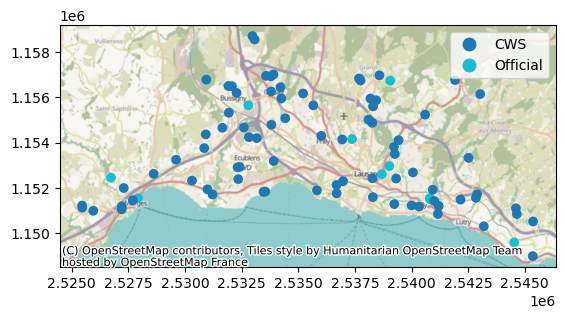

In [ ]:
# use the .loc at the end to select only official and QC CWs
stations_gdf = (
    pd.concat(
        [
            gpd.read_file(stations_gdf_filepath)
            .to_crs(stations_crs)
            .rename(columns={"index": dst_station_id_col})[
                [dst_station_id_col, "geometry"]
            ]
            .assign(source=source)
            for stations_gdf_filepath, source in zip(
                [official_stations_gdf_filepath, cws_stations_gdf_filepath],
                source_labels,
            )
        ]
    )
    .set_index(dst_station_id_col)
    .loc[ts_df.columns]
    .reset_index(names=dst_station_id_col)
)
# plot the geo-data frame
ax = stations_gdf.plot("source", legend=True)
cx.add_basemap(ax, crs=stations_gdf.crs)

In [ ]:
stations_gdf["source"].value_counts()

source
CWS         81
Official    10
Name: count, dtype: int64

In [ ]:
# dump the data
ts_df.to_csv(dst_ts_df_filepath)
stations_gdf.to_file(dst_stations_gdf_filepath)